# Load Packages and Data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from scipy.special import expit

In [20]:
df = pd.read_csv('Survey_2024_Themed.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['End_Date'] = pd.to_datetime(df['End_Date'])
df.info()
df.set_index('ID', inplace=True)



<class 'pandas.DataFrame'>
RangeIndex: 7522 entries, 0 to 7521
Columns: 106 entries, ID to left_any_comment
dtypes: datetime64[us](3), float64(47), int64(48), str(8)
memory usage: 6.1 MB


# Key Driver Analysis

## Identify Key Drivers

In [21]:
#Define data columns of interest
area_cols = [col for col in df.columns if (col.startswith('Area_Sat_') or col.startswith('Adv_Sat_')) and not col.endswith('_Mean') and not col.endswith('_Unattended')]
adv_cols = [col for col in df.columns if col.startswith('Adv_Sat_') and not col.endswith('_Mean')]
sat_cols = [col for col in df.columns if col.startswith('Sat_') and not col.endswith('_Mean')]
theme_cols = [col for col in df.columns if col.startswith('theme_')]
control_cols = ['temp','feelslike','cloudcover','precip', 'Ideal_Weather', 'Membership', "Median_Income",'CCI',"Day_Off","Daily_Rating_Count","Local"]
binary_controls = [
    "Day_Off",
    "Membership",
    "Ideal_Weather", 
    'Local'
]

continuous_controls = [
    c for c in control_cols if c not in binary_controls
]

#Generate new columns of interest
for col in adv_cols:
    df[col + '_Skipped'] = np.where(df[col].isna(), 1, 0)
    
for col in sat_cols:
    df[col + '_Skipped'] = np.where(df[col].isna(), 1, 0)

area_unattended_cols = [col for col in df.columns if col.endswith('_Unattended')]
adv_skipped_cols = [col for col in df.columns if col.startswith('Adv_Sat_') and col.endswith('_Skipped')]
sat_skipped_cols = [col for col in df.columns if col.startswith('Sat_') and col.endswith('_Skipped')]
    
df['Local'] = np.where((df['Residence'] == 'Toronto') | (df['Residence'] == 'GTA (Halton, Peel, York, Durham)'), 1, 0)

df['Recommender'] = np.where(df['Likely_Rec'] >=8,1,0)
y = df["Recommender"].astype(int)
df.to_csv("Survey_2024_Themed_Cleaned.csv", index=True)

df_raw = df.copy()

C:\Users\natha\AppData\Local\Temp\ipykernel_32000\2902675213.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_Skipped'] = np.where(df[col].isna(), 1, 0)
C:\Users\natha\AppData\Local\Temp\ipykernel_32000\2902675213.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_Skipped'] = np.where(df[col].isna(), 1, 0)
C:\Users\natha\AppData\Local\Temp\ipykernel_32000\2902675213.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [4]:
#Impute missing data

#Sub-areas
df[area_cols] = df[area_cols].fillna(3)


#Sub-features
df[sat_cols] = df[sat_cols].fillna(3)


# External Control Predictors
df['Median_Income'] = df['Median_Income'].fillna(df['Median_Income'].median())


In [5]:
# Define fitting and modeling functions so we don't have to do repeat the same code 3 times
# Pretty labeling functions
def pretty_area_name(col: str) -> str:
    return (
        col.replace("Area_Sat_", "")
           .replace("Adv_Sat_", "")
           .replace("_", " ")
    )

def pretty_theme_name(col: str) -> str:
    return (
        col.replace("theme_", "")
           .replace("_", " ")
           .replace("flag", "")
           .strip()
    )

def pretty_sat_name(col: str) -> str:
    s = col.replace("Sat_", "").replace("_", " ")
    s = (s.replace("Variety", "Exhibit Variety")
           .replace("Signs", "Signage")
           .replace("Vol", "Volunteer")
           .replace("Emp", "Employee")
           .replace("Green", "Green Policies")
           .replace("Admission", "Admission Fee")
           .replace("Value", "Value for Cost")
           .replace("Food", "Food Services"))
    return s

def add_pretty_label(df: pd.DataFrame, kind: str) -> pd.DataFrame:
    df = df.copy()
    if kind == "area":
        df["label"] = df["feature"].map(pretty_area_name)
    elif kind == "theme":
        df["label"] = df["feature"].map(pretty_theme_name)
    elif kind == "sat":
        df["label"] = df["feature"].map(pretty_sat_name)
    else:
        df["label"] = df["feature"]
    return df

In [6]:
# Model fitting function
def fit_l1_logit_cv(X: pd.DataFrame, y: pd.Series, Cs=None, random_state=123):
    if Cs is None:
        Cs = np.logspace(-4, 2, 25)

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegressionCV(
            Cs=Cs,
            cv=5,
            penalty="l1",
            solver="liblinear",
            scoring="roc_auc",
            n_jobs=-1,
            refit=True,
            random_state=random_state,
            max_iter=2000
        ))
    ])
    pipe.fit(X, y)
    return pipe

In [7]:
## Generate marginal effects table
def marginal_effects_table(pipe, X, feature_types, baseline="mean"):
    """
    Compute marginal effects (Δ probability) for each feature around a baseline point.

    feature_types: dict feature -> {"type": "binary"|"continuous", "step": ...}
      - binary: step ignored (uses toggle 0->1 in original space)
      - continuous: you can choose:
          step="1sd"  => +1 SD (in z-space this is +1)
          step="1unit"=> +1 original-unit (Δz = 1/sd)

    baseline:
      - "mean" means baseline point is z=0 (all features at mean)
    """
    scaler = pipe.named_steps["scaler"]
    clf = pipe.named_steps["clf"]

    features = X.columns.to_list()
    coef = clf.coef_[0]
    intercept = clf.intercept_[0]

    # baseline z vector at mean = 0
    z0 = np.zeros(len(features))
    p0 = expit(intercept + np.dot(coef, z0))

    # Extract scaler params aligned to X columns
    means = scaler.mean_
    sds = scaler.scale_

    rows = []
    for j, f in enumerate(features):
        if f not in feature_types:
            continue

        ftype = feature_types[f]["type"]
        step = feature_types[f].get("step", "1sd")

        z1 = z0.copy()

        if ftype == "binary":
            # Toggle 0->1 in ORIGINAL units:
            # z = (x - mean)/sd, so delta_z = (1 - 0)/sd = 1/sd
            # (works fine as an approximation around the mean baseline)
            if sds[j] == 0:
                dp = np.nan
            else:
                z1[j] = 1.0 / sds[j]
                p1 = expit(intercept + np.dot(coef, z1))
                dp = p1 - p0

        elif ftype == "continuous":
            if sds[j] == 0:
                dp = np.nan
            else:
                if step == "1unit":
                    z1[j] = 1.0 / sds[j]  # +1 original unit
                else:
                    z1[j] = 1.0          # +1 SD
                p1 = expit(intercept + np.dot(coef, z1))
                dp = p1 - p0
        else:
            continue

        rows.append({
            "feature": f,
            "coef": coef[j],
            "odds_ratio": float(np.exp(coef[j])),
            "delta_prob": float(dp),
            "delta_pp": float(dp * 100) if pd.notna(dp) else np.nan,
            "type": ftype,
            "step": step
        })

    return pd.DataFrame(rows).sort_values("delta_pp", ascending=True)

In [8]:
def sigmoid(z):
    return expit(z)

def get_model_params(pipe: Pipeline):
    scaler = pipe.named_steps["scaler"]
    clf = pipe.named_steps["clf"]
    coef = clf.coef_[0]
    intercept = clf.intercept_[0]
    return scaler, coef, intercept

def delta_prob_for_feature(
    feature: str,
    features: list,
    pipe: Pipeline,
    action_type: str,
    step: float = 1.0,
):
    """
    Computes marginal effect in probability space at the "average respondent"
    (i.e., standardized features = 0).

    action_type:
      - "likert+1": increase by 1 point on the original scale
      - "binary_0to1": 0 -> 1
      - "binary_1to0": 1 -> 0  (useful for complaint flags: "fix the issue")
    """
    scaler, coef, intercept = get_model_params(pipe)
    j = features.index(feature)
    sd = scaler.scale_[j]
    if sd == 0:
        return np.nan

    # baseline at mean in standardized space
    p0 = sigmoid(intercept)

    # convert action into delta in standardized units
    if action_type == "likert+1":
        delta_z = step / sd
    elif action_type == "binary_0to1":
        delta_z = (1.0 - 0.0) / sd
    elif action_type == "binary_1to0":
        delta_z = (0.0 - 1.0) / sd
    else:
        raise ValueError(f"Unknown action_type: {action_type}")

    p1 = sigmoid(intercept + coef[j] * delta_z)
    return p1 - p0


def compute_prevalence(series: pd.Series, prevalence_kind: str):
    """
    prevalence_kind:
      - "flag_rate": mean of binary flag
      - "answered_rate": share answered (non-missing originally, but after impute use *_answered)
      - "dissatisfied_rate": share <= 3 on 1–5 scale (common for actionability)
    """
    if prevalence_kind == "flag_rate":
        return series.mean()
    elif prevalence_kind == "answered_rate":
        return series.mean()
    elif prevalence_kind == "dissatisfied_rate":
        return (series <= 3).mean()
    else:
        raise ValueError(f"Unknown prevalence_kind: {prevalence_kind}")

In [9]:
def build_action_impact_df(
    df_raw: pd.DataFrame,
    pipe: Pipeline,
    X: pd.DataFrame,
    actionable_features: list,
    feature_meta: dict,
):
    """
    feature_meta example:
      {
        "Sat_Value": {"action_type": "likert+1", "step": 1, "prevalence": "dissatisfied_rate"},
        "theme_cost_friction_flag": {"action_type": "binary_1to0", "prevalence": "flag_rate"},
        "Sat_Accessibility_answered": {"action_type": "binary_0to1", "prevalence": "answered_rate"},
      }
    """
    features = X.columns.tolist()

    rows = []
    for f in actionable_features:
        meta = feature_meta.get(f, {})
        action_type = meta.get("action_type", "likert+1")
        step = meta.get("step", 1.0)
        prev_kind = meta.get("prevalence", None)
        prev_col = meta.get("prevalence_col", f)  # can override

        # marginal effect at average respondent
        dprob = delta_prob_for_feature(
            feature=f,
            features=features,
            pipe=pipe,
            action_type=action_type,
            step=step
        )

        # prevalence
        if prev_kind is None:
            # sensible defaults
            if action_type.startswith("binary"):
                prev_kind = "flag_rate"
            else:
                prev_kind = "dissatisfied_rate"

        prev = compute_prevalence(df_raw[prev_col], prev_kind)

        rows.append({
            "feature": f,
            "prevalence": prev,
            "marginal_effect": dprob,
            "abs_lift": abs(prev * dprob),  # absolute pp lift for ranking
            "signed_lift": prev * dprob,    # keep if you want direction
        })

    out = pd.DataFrame(rows)
    out["prevalence_pct"] = out["prevalence"] * 100
    out["marginal_effect_pp"] = out["marginal_effect"] * 100
    out["abs_lift_pp"] = out["abs_lift"] * 100
    out = out.sort_values("abs_lift_pp", ascending=False)
    return out

In [10]:
def plot_driver_quadrant(
    aidf: pd.DataFrame,
    title: str,
    exclude_features=None,
    xlim=None,
    ylim=None,
):
    if exclude_features is None:
        exclude_features = set()
    else:
        exclude_features = set(exclude_features)

    d = aidf[~aidf["feature"].isin(exclude_features)].copy()

    # Medians
    x_med = d["prevalence_pct"].median()
    y_med = d["marginal_effect_pp"].median()

    fig, ax = plt.subplots(figsize=(11, 8))
    ax.scatter(d["prevalence_pct"], d["marginal_effect_pp"])

    # label every point
    for _, r in d.iterrows():
        ax.annotate(
            r.get("label", r["feature"]),
            (r["prevalence_pct"], r["marginal_effect_pp"]),
            xytext=(7, 5),
            textcoords="offset points",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.65)
        )

    ax.axvline(x_med, linestyle="--")
    ax.axhline(y_med, linestyle="--")

    ax.set_xlabel("Prevalence (% affected)")
    ax.set_ylabel("Marginal effect (pp)")
    ax.set_title(title)

    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)

    plt.tight_layout()
    plt.show()

    return fig, ax

In [11]:
def clean_action_df(aidf: pd.DataFrame, top_n=30):
    out = aidf.copy()
    out = out[["label", "prevalence_pct", "marginal_effect_pp", "abs_lift_pp"]].copy()
    out = out.rename(columns={
        "label": "Driver",
        "prevalence_pct": "Prevalence (%)",
        "marginal_effect_pp": "Marginal effect (pp)",
        "abs_lift_pp": "Absolute lift (pp)"
    })
    # nice rounding
    for c in ["Prevalence (%)", "Marginal effect (pp)", "Absolute lift (pp)"]:
        out[c] = out[c].astype(float).round(2)
    return out.head(top_n)

In [12]:
# Model Themes
X_themes = df[theme_cols + control_cols]
y = df["Recommender"].astype(int)

pipe_themes = fit_l1_logit_cv(X_themes, y, random_state=123) 

meta_themes = {}
for c in theme_cols:
    # complaint flag: action is to remove the complaint (1 -> 0)
    meta_themes[c] = {"action_type": "binary_1to0", "prevalence": "flag_rate"}

aidf_themes = build_action_impact_df(
    df_raw = df_raw,
    pipe=pipe_themes,
    X=X_themes,
    actionable_features=theme_cols,
    feature_meta=meta_themes
)
aidf_themes = add_pretty_label(aidf_themes, kind="theme")

table_themes = clean_action_df(aidf_themes, top_n=10)
display(table_themes)

c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit

,Driver,Prevalence (%),Marginal effect (pp),Absolute lift (pp)
2,animal visibility availability,7.88,18.94,1.49
3,construction closures disruption,6.41,18.08,1.16
6,operational reliability,6.95,12.60,0.88
4,amenities comfort,8.77,6.18,0.54
5,cost value pricing,2.15,22.49,0.48
1,navigation info,1.71,2.47,0.04
0,mobility accessibility,4.96,0.16,0.01


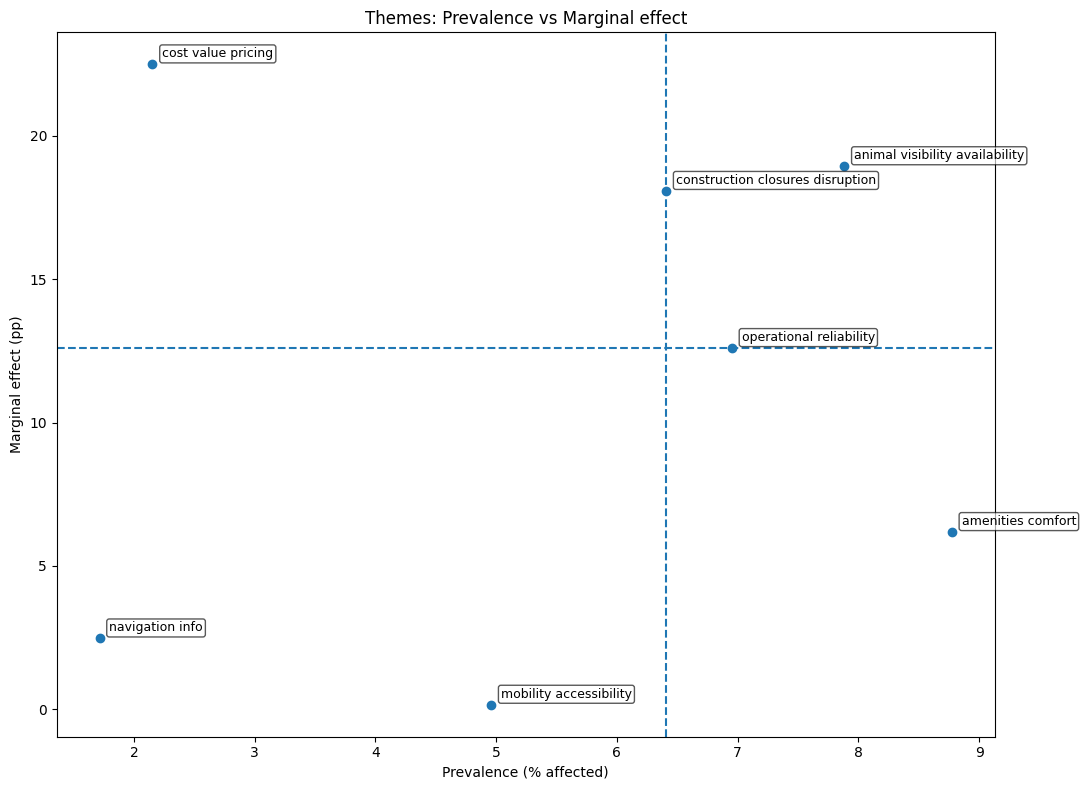

(<Figure size 1100x800 with 1 Axes>,
 <Axes: title={'center': 'Themes: Prevalence vs Marginal effect'}, xlabel='Prevalence (% affected)', ylabel='Marginal effect (pp)'>)

In [13]:
plot_driver_quadrant(
    aidf_themes,
    title="Themes: Prevalence vs Marginal effect",
    exclude_features=[],
)

In [14]:
# Model Global Satisfaction
X_sat = df[sat_cols + sat_skipped_cols + control_cols]


pipe_sat = fit_l1_logit_cv(X_sat, y, random_state=123) 

meta_sat = {}
for c in sat_cols:
    meta_sat[c] = {"action_type": "likert+1", "step": 1.0, "prevalence": "dissatisfied_rate"}

aidf_sat = build_action_impact_df(
    df_raw = df_raw,
    pipe=pipe_sat,
    X=X_sat,
    actionable_features=sat_cols,
    feature_meta=meta_sat
)
aidf_sat = add_pretty_label(aidf_sat, kind="sat")

table_sat = clean_action_df(aidf_sat, top_n=10)
display(table_sat)

c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit

,Driver,Prevalence (%),Marginal effect (pp),Absolute lift (pp)
0,Value for Cost,43.95,14.95,6.57
2,Exhibit Variety,28.04,11.12,3.12
10,Food Services,37.98,3.60,1.37
6,Parking,37.00,2.41,0.89
4,Map,28.80,2.51,0.72
3,Signage,35.54,1.86,0.66
13,Accessibility,18.94,3.23,0.61
9,Gift Shops,22.56,2.65,0.60
5,Admission Fee,37.57,1.38,0.52
7,Employee Helpfulness,14.13,3.39,0.48


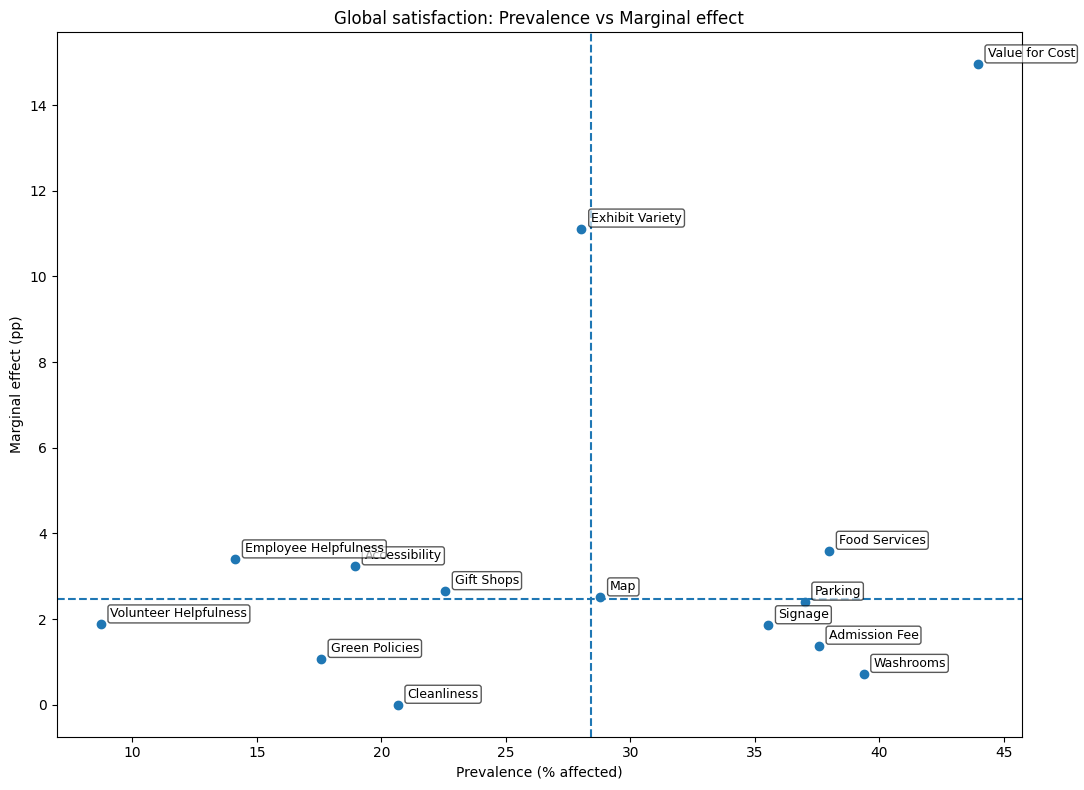

(<Figure size 1100x800 with 1 Axes>,
 <Axes: title={'center': 'Global satisfaction: Prevalence vs Marginal effect'}, xlabel='Prevalence (% affected)', ylabel='Marginal effect (pp)'>)

In [15]:
plot_driver_quadrant(
    aidf_sat,
    title="Global satisfaction: Prevalence vs Marginal effect",
    exclude_features=[],
)

In [16]:
# Model Sub Area Satisfaction
X_area = df[area_cols + area_unattended_cols + adv_skipped_cols + control_cols]


pipe_area = fit_l1_logit_cv(X_area, y, random_state=123) 

meta_area = {}
for c in area_cols:
    meta_area[c] = {"action_type": "likert+1", "step": 1.0, "prevalence": "dissatisfied_rate"}

aidf_area = build_action_impact_df(
    df_raw = df_raw,
    pipe=pipe_area,
    X=X_area,
    actionable_features=area_cols,
    feature_meta=meta_area
)
aidf_area = add_pretty_label(aidf_area, kind="area")

table_area = clean_action_df(aidf_area, top_n=10)
display(table_area)

c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit

,Driver,Prevalence (%),Marginal effect (pp),Absolute lift (pp)
3,African Savannah,24.30,9.96,2.42
1,Eurasian Wilds,25.84,8.95,2.31
0,Tundra Trek,24.95,9.20,2.30
8,Indo Malaya Pavilion,21.28,6.80,1.45
5,African Rainforest Pavilion,19.74,6.07,1.20
7,Americas Pavilion,20.01,5.26,1.05
4,Canadian Domain,17.43,5.59,0.97
6,Australasia Pavilion,21.76,4.16,0.90
14,Zoomobile,10.09,8.57,0.87
13,Conservation Carousel,7.39,8.44,0.62


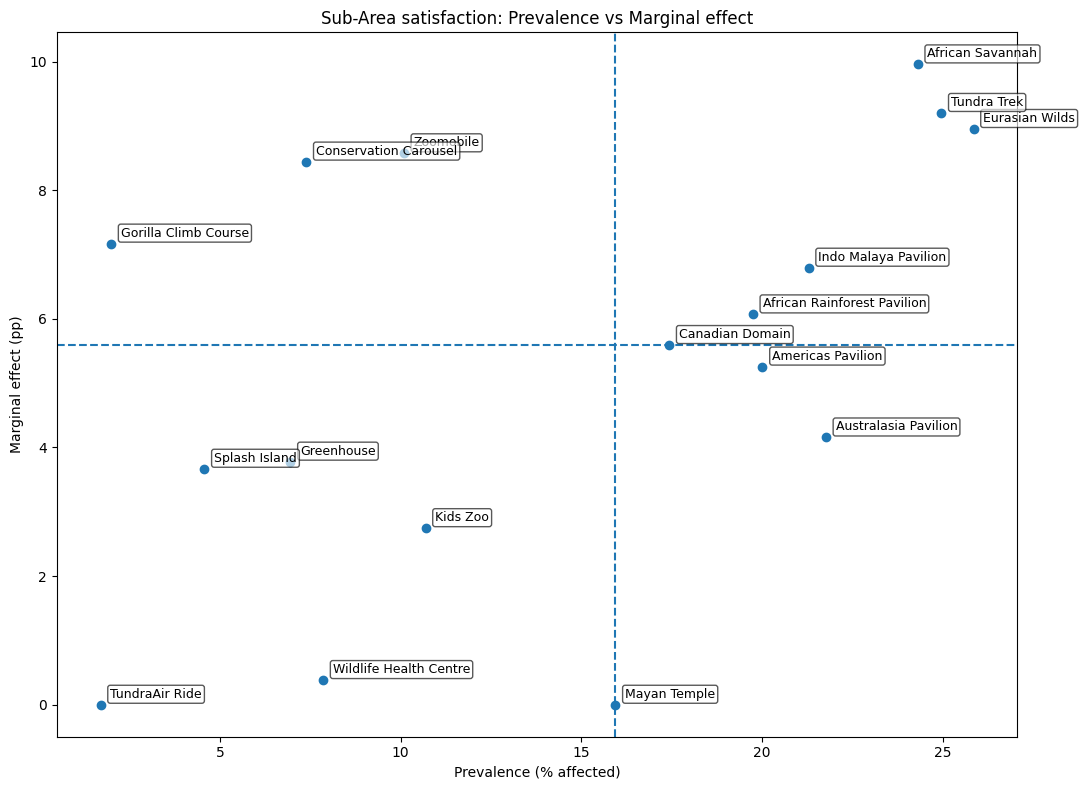

(<Figure size 1100x800 with 1 Axes>,
 <Axes: title={'center': 'Sub-Area satisfaction: Prevalence vs Marginal effect'}, xlabel='Prevalence (% affected)', ylabel='Marginal effect (pp)'>)

In [17]:
plot_driver_quadrant(
    aidf_area,
    title="Sub-Area satisfaction: Prevalence vs Marginal effect",
    exclude_features=[],
)